In [35]:
import abc
import os
import random

import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(os.urandom(16))

In [36]:
class RandomVariable(abc.ABC):
    @abc.abstractmethod
    def generate(self) -> int | float:
        pass

    @abc.abstractmethod
    def generate_n(self, n: int) -> tuple[np.ndarray, np.ndarray]:
        pass

    def __call__(self, *args, **kwargs):
        return self.generate()


class DiscreteRandomVariable(RandomVariable, abc.ABC):
    @abc.abstractmethod
    def generate(self) -> int:
        pass

    def generate_n(self, n: int) -> tuple[np.ndarray, np.ndarray]:
        raw = np.array([self.generate() for _ in range(n)])
        values, counts = np.unique(raw, return_counts=True)
        return values, counts


class ContinuousRandomVariable(RandomVariable, abc.ABC):
    @abc.abstractmethod
    def generate(self) -> float:
        pass

    def generate_n(self, n: int) -> tuple[np.ndarray, np.ndarray]:
        raw = np.array([self.generate() for _ in range(n)])
        k = int(np.floor(1 + np.log2(raw.size)))
        bins = np.linspace(np.floor(raw.min()), np.ceil(raw.max()), k)
        return np.histogram(raw, bins=bins)

## Параметры

In [37]:
# Параметр лямбда для пуассоновской случайной переменной
LAMBDA_POISSON = 0.5
# Параметр лямбда для экспоненциальной случайной переменной
LAMBDA_EXP = 0.2
# Количество экспериментов
N = 200
# Уровень значимости
ALPHA = 0.05

## Пуассоновская случайная переменная

In [38]:
class Poisson(DiscreteRandomVariable):
    def __init__(self, lambda_: float):
        self._lambda = lambda_

    @property
    def lambda_(self) -> float:
        return self._lambda

    @lambda_.setter
    def lambda_(self, value: float):
        self._lambda = value

    def generate(self) -> int:
        u = np.random.uniform(0, 1)
        i = 0
        f = p = np.exp(-self._lambda)
        while u >= f:
            p = self._lambda * p / (i + 1)
            f += p
            i += 1
        return i


In [39]:
@np.vectorize
def poisson_prob(lambda_: float, i: int) -> float:
    return np.exp(-lambda_) * (lambda_ ** i / np.math.factorial(i))

def chi2_poisson(values: np.ndarray, counts: np.ndarray) -> tuple[float, int, pd.DataFrame]:
    n = int(np.sum(counts))
    lambda_s = np.sum(values * counts) / n
    if n > 5:
        while counts[-1] < 5 and len(counts) > 2:
            counts[-2] += counts[-1]
            counts = counts[:-1]
            values = values[:-1]
    p = poisson_prob(lambda_s, values)
    ni = p * n
    delta_n = counts - ni
    delta_n2 = delta_n ** 2
    k = delta_n2 / ni
    table = pd.DataFrame({"i": values, "n_i": counts, "n'_i": ni, "n_i - n'_i": delta_n, "(n_i - n'_i)^2": delta_n2, "K": k}).set_index('i', drop=True)
    df = len(values) - 2
    return float(np.sum(k)), df, table

,n_i
x_i,
0,113
1,73
2,9
3,3
4,2


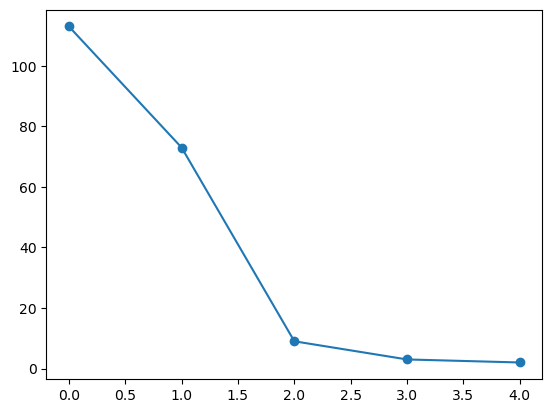

In [40]:
poisson = Poisson(LAMBDA_POISSON)
vals, c = poisson.generate_n(N)
t = pd.DataFrame({"x_i": vals, "n_i": c}).set_index("x_i", drop=True)
display(t)
plt.scatter(vals, c)
plt.plot(vals, c)

In [41]:
chi2, df, t = chi2_poisson(vals.copy(), c.copy())
display(t)
chi2_crit = scipy.stats.chi2.isf(ALPHA, df=df, loc=0, scale=1)

dft = pd.DataFrame.from_dict({
    "df": df,
    "chi2": chi2,
    "chi2_crit": chi2_crit,
    "H0": "принимаем" if chi2 < chi2_crit else "отвергаем"
}, orient="index")
display(dft)

,n_i,n'_i,n_i - n'_i,(n_i - n'_i)^2,K
i,,,,,
0,113,116.549650,-3.549650,12.600018,0.108109
1,73,62.936811,10.063189,101.267768,1.609039
2,9,16.992939,-7.992939,63.887074,3.759625
3,5,3.058729,1.941271,3.768533,1.232058


,0
df,2
chi2,6.708831
chi2_crit,5.991465
H0,отвергаем


## Экспоненциальная случайная переменная

In [42]:
class Exponential(ContinuousRandomVariable):
    def __init__(self, lambda_: float):
        self._lambda = lambda_

    @property
    def lambda_(self) -> float:
        return self._lambda

    @lambda_.setter
    def lambda_(self, value: float):
        self._lambda = value

    def generate(self) -> float:
        u = np.random.uniform(0, 1)
        return -1 / self._lambda * np.log(1 - u)


exponential = Exponential(LAMBDA_EXP)

In [43]:
@np.vectorize
def exp_prob(lambda_: float, start: float, end: float) -> float:
    return np.exp(-lambda_ * start) - np.exp(-lambda_ * end)

def chi2_exp(bins: np.ndarray, counts: np.ndarray) -> tuple[float, int, pd.DataFrame]:
    n = int(np.sum(counts))
    values = (bins[1:] + bins[:-1]) / 2
    x_b = np.sum(values * counts) / n
    if n > 5:
        while counts[-1] < 5 and len(counts) > 2:
            counts[-2] += counts[-1]
            counts = counts[:-1]
            bins = bins[:-1]
            values = values[:-1]
    lambda_s = 1 / x_b
    p = exp_prob(lambda_s, bins[:-1], bins[1:])
    ni = p * n
    delta_n = counts - ni
    delta_n2 = delta_n ** 2
    k = delta_n2 / ni
    table = pd.DataFrame({"i": values, "n_i": counts, "n'_i": ni, "n_i - n'_i": delta_n, "(n_i - n'_i)^2": delta_n2, "K": k}).set_index('i', drop=True)
    df = len(values) - 2
    return float(np.sum(k)), df, table

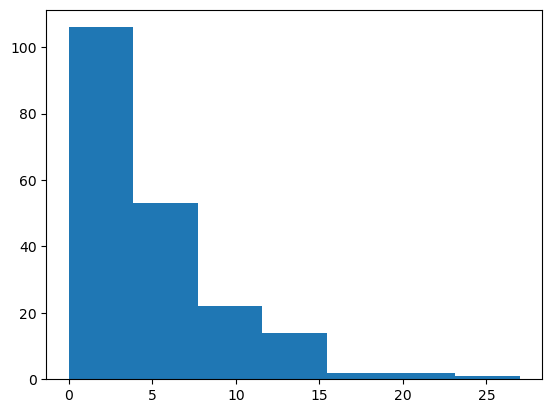

In [44]:
c, b = exponential.generate_n(N)
plt.stairs(c, b, fill=True)

In [45]:
chi2, df, t = chi2_exp(b.copy(), c.copy())
display(t)
chi2_crit = scipy.stats.chi2.isf(ALPHA, df=df, loc=0, scale=1)

dft = pd.DataFrame.from_dict({
    "df": df,
    "chi2": chi2,
    "chi2_crit": chi2_crit,
    "H0": "принимаем" if chi2 < chi2_crit else "отвергаем"
}, orient="index")
display(dft)

,n_i,n'_i,n_i - n'_i,(n_i - n'_i)^2,K
i,,,,,
1.928571,106,106.509382,-0.509382,0.259470,0.002436
5.785714,53,49.788140,3.211860,10.316046,0.207199
9.642857,22,23.273620,-1.273620,1.622108,0.069697
13.500000,14,10.879326,3.120674,9.738609,0.895148
17.357143,5,5.085574,-0.085574,0.007323,0.001440


,0
df,3
chi2,1.17592
chi2_crit,7.814728
H0,принимаем
